# Medicina Personalizada - Redefinindo o Tratamento de Câncer

Muito tem sido dito durante os últimos anos sobre como a medicina de
precisão e, mais concretamente, como o teste genético, vai provocar disrupção no
tratamento de doenças como o câncer.

Mas isso ainda está acontecendo apenas parcialmente devido à enorme
quantidade de trabalho manual ainda necessário. Neste projeto, tentaremos levar
a medicina personalizada ao seu potencial máximo.

Uma vez sequenciado, um tumor cancerígeno pode ter milhares de
mutações genéticas. O desafio é distinguir as mutações que contribuem para o
crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita
manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem
que revisar manualmente e classificar cada mutação genética com base em
evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) está
disponibilizando uma base de conhecimento anotada por especialistas, onde
pesquisadores e oncologistas de nível mundial anotaram manualmente milhares
de mutações.

Neste projeto, você vai desenvolver um algoritmo de Aprendizado de
Máquina que, usando essa base de conhecimento como uma linha de base,
classifica automaticamente as variações genéticas.

O dataset completo pode ser encontrado em:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

Este projeto faz parte do curso Machine Learning da Data Science Academy

#### Preparando as bibliotecas a serem utilizadas

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from keras.models import Sequential,Input,Model, load_model
from keras.metrics import AUC
from keras.layers import Dense
from keras.utils import plot_model,to_categorical
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import keras.regularizers as regularizers

from tensorflow.compat.v1.keras.backend import set_session,clear_session,get_session
from tensorflow.compat.v1 import Session
import gc

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scikitplot as skplt
import tensorflow as tf
import re
import string
import scipy.sparse as sp
from scipy.stats import boxcox, zscore

from os import listdir

import json

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize

import pickle
from collections import Counter
from functools import reduce
from wordcloud import WordCloud

from numba import cuda

In [2]:
#Teste de GPU
!nvidia-smi

Mon Sep 14 21:53:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8    N/A /  N/A |     78MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
#Checando a quantidade de GPU´s disponíveis
print("Número Disponível de GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Número Disponível de GPUs:  1


Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

* __training_variants__ - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)
* **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)
* __test_variants__ - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)
* **test_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

#### Biblioteca de funções a ser utilizadas

In [2]:
#função para ler os arquivos variant disponibilizados e convertendo em dataframe
def convert_variant_df(read):
    lista = open(read, "r",encoding="utf8").readlines()
    #Esta lista possui \n junto ao texto, entao vamos remover
    lista_nova = [texto.split(sep="\n")[0].split(",") for texto in lista]
    df = pd.DataFrame(lista_nova[1:],columns=lista_nova[0])
    return(df)

#função para converter os demais arquivos em dataframe
def convert__df(read):
    #separa o texto pelo delimitador ||
    lista = re.split('([0-9]+)(\|\|)',open(read, "r",encoding="utf8").read())
    #Remove da lista os elementos ||
    lista = [elemento for elemento in lista if elemento != "||"]
    #Detecta o titulo do df
    titulo = lista[0].split("\n")[0].split(",")
    lista_nova= [[lista[index+1],lista[index+2]] for index in range(0,len(lista[1:])-1,2)]
    
    df = pd.DataFrame(lista_nova,columns=titulo)
    return(df) 

# Criando uma função que retorna um dataframe de descrição de dados (tal qual a função describe do pacote explore do R)
def explore_describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [sum(df[coluna].isna()) for coluna in df.columns]
    df_out['na_pct'] = [str(round(100*sum(df[coluna].isna())/df.shape[0],1))+'%' for coluna in df.columns]
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [round(min(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [round(max(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [round(df[coluna].skew(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [round(df[coluna].kurt(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    
    df_out_media_desvio_list = []
    for coluna in df.columns:
        if(('int' in str(df[coluna].dtype)) or ('float' in str(df[coluna].dtype)) ):
            if((all(df[coluna] == 0)) or (df[coluna].std() == 0)):
                df_out_media_desvio_list.append(0)
            else:
                df_out_media_desvio_list.append(round(df[coluna].mean()/df[coluna].std(),2))
        else:
            df_out_media_desvio_list.append('-')
    
    df_out['media_desvio'] = df_out_media_desvio_list
    return(df_out)

#função para remover caracteres não ASCII
def removeNoAscii(s):
    return "".join(i for i in s if ord(i) < 128)

#Função para gerar corpus (lista de documentos)
def corpusnization(text):
    #Removendo a pontuação e tokenizando
    nopunct_token = regexp_tokenize(text.lower(),"[\w']+")
   
    #Removendo stopwords
    token_no_stopwords = [word for word in nopunct_token if word not in stopwords.words('english')]
    
    #Stemming
    #cooking -> cook
    token_stem = [PorterStemmer().stem(token) for token in token_no_stopwords]
    
    #Lemmatization
    #mice -> mouse
    token_final = [WordNetLemmatizer().lemmatize(token) for token in token_stem]
    return(token_stem)

#função para criar o set de palavras (em ordem alfabética e sem repetição)
def cria_listagem_palavras(corpus):
    listagem = set()
    for i in corpus:
        listagem = listagem.union(set(i))
    return(listagem)

#Esta função irá retornar uma estrutra para o dicionario de palavras, atribuindo indices a elas
def cria_dicionario_palavras(listagem):
    dicionario = {i:j for j,i in enumerate(listagem)}
    return(dicionario)

# Vamos contar a quantidade de palavras em cada elemento do corpus
def conta_palavras_corpus(elem_corpus):
    return dict(Counter(elem_corpus))

#Função para criar o dicionario de palavras
def df_dict(listagem,bag_words_corpus):
    return {token: sum([token in doc.keys() for doc in bag_words_corpus]) for token in listagem}

    

#tf(termo,documento) = contagem de termo em documento / número de palavras em documento
#idf (termo) = log (N / (df + 1))

#tf-idf (termo, documento) = tf (termo, documento) * log (N / (df + 1))
def calcula_tf_e_idf(bow, df,N):
    #Calculando a frequencia do termo para cada documento
    tf = [{key:t/sum(documento.values()) for key,t in documento.items()} for documento in bow]
    idf = {chave: np.log(N/(valor+1))  for chave,valor in df.items()}
    return (tf,idf)
    

def tf_idf(lista_tf,dict_idf):
    return [{chave: tf*dict_idf[chave] for chave,tf in doc.items()} for doc in lista_tf]

# Função para criar nuvem de palavras
def word_cloud_plot(classe,df,bag_words):
    indices = df[df["Class"] == classe].index
    bag_words_filtrada = [bag_words[i] for i in indices]
    dicionario_classe = reduce(lambda x,y: Counter(x) + Counter(y), bag_words_filtrada)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(dicionario_classe)
    return(wordcloud)


#Função que cria uma nuvem de palvras baseado não na frequencia, mas sim, no TF IDF
def word_cloud_plot_tfidf(classe,df,lista_tfidf):
    indices = df[df["Class"] == classe].index
    lista_tfidf_filtrada = [lista_tfidf[i] for i in indices]
    dicionario_classe_tf_idf = reduce(lambda x, y: dict((chave, valor + y[chave]) if chave in y.keys() else (chave, valor) for chave, valor in x.items()), lista_tfidf_filtrada)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(dicionario_classe_tf_idf)
    return(wordcloud)

#Função para plotar a nuvem e palavras
def plota_wordcloud(func,df,lista_dicionario_palavras):
    fig = plt.figure(figsize=(20,10))
    for i in range(1,10):
        ax = fig.add_subplot(3,3,i)
        ax.imshow(func(i,df,lista_dicionario_palavras))
        ax.set_title(str(i))
        plt.axis("off")
    plt.show()

# Para criar o modelo base, precisamos de uma base de dados inicial. Para isso, vamos criar o dataset usando as palavras da listagem
def matriz_esparca(dicio,tfidf_,N_):
    S = sp.dok_matrix((N_,len(dicio)),dtype = np.float32)
    for i,doc in enumerate(tfidf_):
        for chave,valor in doc.items():
            S[i,dicio[chave]] = valor
    
    return S

#Função para converter a matriz esparça em tfSparce
def convert_matriz_esparca_tfSparce(M):
    coo = M.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return(tf.SparseTensor(indices, coo.data, coo.shape))

#Função para criar sempre os mesmos arquivos de treino e validação, para não termos diferenças nos treinamentos
def train_test_valid_split(df_treino):
    #Dividindo os dados de treino e teste, para verificar o quao bom nosso modelo está
    #O stratify servirá para melhor dividirmos os dados
    x_train, x_test, y_train, y_test = train_test_split(df_treino.drop(columns = "Class"), df_treino["Class"], 
                                                        test_size=0.3, random_state=42,stratify = df_treino["Class"])
    x_train,x_valid,y_train,y_valid =  train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify = y_train)
    
    return (x_train,x_test,x_valid,y_train,y_test,y_valid)

#Variáveis de entrada
def dados_modelo_treino_valid(x_train,x_test,x_valid,df_training,d,TFIDF,n):
    X = matriz_esparca(d,TFIDF,n)
    
    X_train = convert_matriz_esparca_tfSparce(X[x_train.index,:])
    X_test = convert_matriz_esparca_tfSparce(X[x_test.index,:])
    X_valid = convert_matriz_esparca_tfSparce(X[x_valid.index,:])

    #Classes (vamos colocar as classes de 0 a 8)
    Y = df_training.Class.apply(lambda x: x-1).to_numpy()
    Y_train = to_categorical(Y[x_train.index])
    Y_test = to_categorical(Y[x_test.index])
    Y_valid = to_categorical(Y[x_valid.index])
    
    return(X,X_train,X_test,X_valid,Y_train,Y_test,Y_valid)

def start_training(modelo, saving_checkpoint_path, nome_modelo, X_train, Y_train, X_valid, Y_valid,
                   batch_size = 20, saved_checkpoint_path = None, modelo_checkpoint = None,
                   earlyStopping = None,  reduce_lr_loss = None, initial_epoch = 0):
    
    #Verifica se há um ModelCkeckpoint customizado
    if modelo_checkpoint is None:
        modelo_checkpoint = ModelCheckpoint("".join((saving_checkpoint_path,nome_modelo,".hdf5")), 
                                            save_best_only=True, monitor='val_loss', mode='min')
    
    #Verifica se há um EarlyStopping customizado
    if earlyStopping is None:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, 
                                      verbose=1, mode='min')
    
    #Verifica se há um ReduceLROnPlateau customizado
    if reduce_lr_loss is None:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, 
                                           verbose=1, min_delta=1e-4, mode='min')
        
    #Verifica se o treinamento começou e já existe um checkpoint salvo
    versao_history = ""
    if saved_checkpoint_path is not None:
        # Load model:
        modelo = load_model(saved_checkpoint_path)
        # Finding the epoch index from which we are resuming
        initial_epoch = get_init_epoch(saved_checkpoint_path)
        arquivos_saved_checkpoint_path = listdir(saved_checkpoint_path)
        versao_history = [i for i in listdir(saved_checkpoint_path) if "".join(("history",nome_modelo)) in i]
        
    modelo.fit(X_train,Y_train,epochs=150,
                   validation_data = (X_valid,Y_valid),
                   batch_size=batch_size,shuffle=True, initial_epoch= initial_epoch,
                   callbacks=[earlyStopping, modelo_checkpoint, reduce_lr_loss])
    
    #Convertendo para float o lr, para que possa ser salvo
    modelo.history.history["lr"] = [float(i) for i in modelo.history.history["lr"] ]
    with open("".join((saving_checkpoint_path,"history_",nome_modelo,versao_history,".json")), 'w') as file:
        json.dump(modelo.history.history, file)
        
    return modelo

def plot_matriz_confusao(modelo,xTeste,yTeste):
    skplt.metrics.plot_confusion_matrix(y_pred=tf.argmax(modelo.predict(xTeste), axis = 1)+1,
                                    y_true=yTeste.argmax(axis=1)+1,
                                    figsize=(12,12))
    plt.title("".join(('Matriz de Confusão - Acuracia:',
             str(round(accuracy_score(y_pred=tf.argmax(modelo.predict(xTeste), axis = 1)+1,
                                        y_true=yTeste.argmax(axis=1)+1),2)),
             ' - Acurácia balanceada:',
             str(round(balanced_accuracy_score(y_pred=tf.argmax(modelo.predict(xTeste), axis = 1)+1,
                                        y_true=yTeste.argmax(axis=1)+1),2)))))
    plt.show()

    #Função para remover palavras indesejadas no corpus
def remove_palavras(listagem,bag_words_corpus,palavras_remover):
    l = listagem.copy()
    bow_corpus = bag_words_corpus.copy()
    palavras_remover = set(palavras_remover)
    print("Conjunto de palavras a remover concluído")
    l = [palavra for palavra in l if palavra not in palavras_remover]
    print("Listagem nova concluida")
    bow_corpus = [{chave: valor for chave,valor in doc.items() if chave not in palavras_remover} for doc in bow_corpus]
    print("BOW concluído")
    d = cria_dicionario_palavras(l)
    print("Dicionário novo concluído")
    n = len(d)
    doc_freq = df_dict(l,bow_corpus)
    print("DoqFreq novo concluído")
    TF,IDF = calcula_tf_e_idf(bow_corpus, doc_freq,n)
    print("TF e IDF novos concluídos")
    TFIDF = tf_idf(TF,IDF)
    print("TFIDF novo concluído")
    return(l,bow_corpus,d,n,doc_freq,TF,IDF,TFIDF)

#Função de plotagem do historico de treinamento: evolução da perda dos dados de treino e validação
def plot_treinamento(historico):
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    plt.plot(historico["loss"])
    plt.plot(historico["val_loss"])

    plt.legend(("Dados de Treino","Dados de Validação"))

    plt.title("Entropia Cruzada Categórica")

    plt.subplot(2,1,2)

    plt.plot(historico["categorical_accuracy"])
    plt.plot(historico["val_categorical_accuracy"])
    plt.title("Acurácia Categórica")
    plt.legend(("Dados de Treino","Dados de Validação"))
    
    plt.show()

    #Função para resetar o keras
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier 
    except:
        pass

    print(gc.collect()) 


    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(Session(config=config))

In [23]:
training_text = "./data_files/training_text"
training_variants = "./data_files/training_variants"

#### Lendo os arquivos de entrada e convertendo os dados lidos em dataframes

In [26]:
df_training_text = convert__df(training_text)
df_training_variants = convert_variant_df(training_variants)


#### Função para exploração inicial de dados

In [28]:
df_training = df_training_text.merge(right=df_training_variants,on = 'ID').drop(columns = "ID")
df_training

Text    Gene  \
0     Cyclin-dependent kinases (CDKs) regulate a var...  FAM58A   
1      Abstract Background  Non-small cell lung canc...     CBL   
2      Abstract Background  Non-small cell lung canc...     CBL   
3     Recent evidence has demonstrated that acquired...     CBL   
4     Oncogenic mutations in the monomeric Casitas B...     CBL   
...                                                 ...     ...   
3316  Introduction  Myelodysplastic syndromes (MDS) ...   RUNX1   
3317  Introduction  Myelodysplastic syndromes (MDS) ...   RUNX1   
3318  The Runt-related transcription factor 1 gene (...   RUNX1   
3319  The RUNX1/AML1 gene is the most frequent targe...   RUNX1   
3320  The most frequent mutations associated with le...   RUNX1   

                 Variation Class  
0     Truncating Mutations     1  
1                    W802*     2  
2                    Q249E     2  
3                    N454D     3  
4                    L399V     4  
...                    ...   ...  
3316                 D171N     4  
3317                 A122*     1  
3318               Fusions     1  
3319                  R80C     4  
3320                  K83E     4  

[3321 rows x 4 columns]

In [30]:
#Checando os dados iniciais
explore_describe(df_training)

variable    type  na na_pct  unique min quat25 median mean quat75 max std  \
0       Text  object   0   0.0%    1921   -      -      -    -      -   -   -   
1       Gene  object   0   0.0%     264   -      -      -    -      -   -   -   
2  Variation  object   0   0.0%    2996   -      -      -    -      -   -   -   
3      Class  object   0   0.0%       9   -      -      -    -      -   -   -   

  skewness kurtosis media_desvio  
0        -        -            -  
1        -        -            -  
2        -        -            -  
3        -        -            -

#### Vamos salvar os df no formato csv para facilitar o carregamento posterior

In [ ]:
df_training.to_csv("df_training.csv")

#### Vamos importar os arquivos csv

In [2]:
df_training = pd.read_csv("df_training.csv")

In [32]:
# Primeiramente, vamos criar a frequencia de cada termo
textos_treino = df_training.Text

In [34]:
textos_treino_limpa = textos_treino.map(lambda x: removeNoAscii(x))

In [36]:
textos_treino_limpa.head()

0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
2     Abstract Background  Non-small cell lung canc...
3    Recent evidence has demonstrated that acquired...
4    Oncogenic mutations in the monomeric Casitas B...
Name: Text, dtype: object

#### Criando gerando o CORPUS para tratamento dos dados

In [8]:
#Removendo a pontuação, stopwords, realizando stemming e lemmatization (essa célula pode demorar algumas horas para ser executada)
treino_corpus = [corpusnization(texto) for texto in textos_treino_limpa]

In [9]:
#Armazenando os corpus (como a célula acima demora algumas horas, será necessário salvar os dados)
with open('treino_corpus.pkl', 'wb') as f:
        pickle.dump(treino_corpus, f)     

## Carregando os dataframe e os corpus

In [3]:
#Carregando novamente os dados. Por demorar para realizar a função corpusnization para tanto os dados de treino quanto os dados de teste, 
#criamos um checkpoint aqui para dar continuidade ao trabalho mais rapidamente

with open('treino_corpus.pkl', 'rb') as f:
        treino_corpus = pickle.load(f)
        
df_training = pd.read_csv("df_training.csv")

In [7]:
treino_corpus[1]

['abstract',
 'background',
 'non',
 'small',
 'cell',
 'lung',
 'cancer',
 'nsclc',
 'heterogen',
 'group',
 'disord',
 'number',
 'genet',
 'proteom',
 'alter',
 'c',
 'cbl',
 'e3',
 'ubiquitin',
 'ligas',
 'adaptor',
 'molecul',
 'import',
 'normal',
 'homeostasi',
 'cancer',
 'determin',
 'genet',
 'variat',
 'c',
 'cbl',
 'relationship',
 'receptor',
 'tyrosin',
 'kinas',
 'egfr',
 'met',
 'function',
 'nsclc',
 'method',
 'find',
 'use',
 'archiv',
 'formalin',
 'fix',
 'paraffin',
 'embed',
 'ffpe',
 'extract',
 'genom',
 'dna',
 'show',
 'c',
 'cbl',
 'mutat',
 'occur',
 'somat',
 'fashion',
 'lung',
 'cancer',
 'c',
 'cbl',
 'mutat',
 'mutual',
 'exclus',
 'met',
 'egfr',
 'mutat',
 'howev',
 'independ',
 'p53',
 'kra',
 'mutat',
 'normal',
 'tumor',
 'pairwis',
 'analysi',
 'signific',
 'loss',
 'heterozygos',
 'loh',
 'c',
 'cbl',
 'locu',
 '22',
 'n',
 '8',
 '37',
 'none',
 'sampl',
 'reveal',
 'mutat',
 'remain',
 'copi',
 'c',
 'cbl',
 'c',
 'cbl',
 'loh',
 'also',
 'posi

#### Verificando a quantidade de classes no dataset

Nota-se que a quantidade de classes está desbalanceada

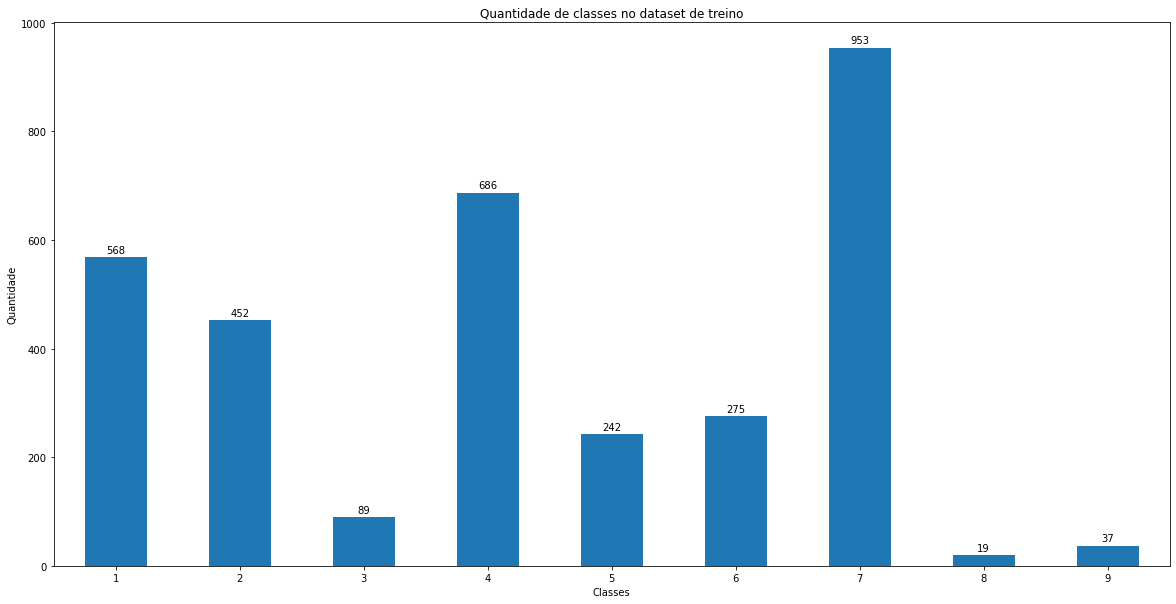

In [3]:
plt.figure(figsize=(20,10))
ax = df_training["Class"].value_counts().sort_index().plot(kind = "bar")
plt.xticks(rotation = 0)
plt.xlabel("Classes")
plt.ylabel("Quantidade")
plt.title("Quantidade de classes no dataset de treino")
rects = ax.patches

for rect, label in zip(rects, list(df_training["Class"].value_counts().sort_index())):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

## Criando dicionário de palavras

In [5]:
#Usando as palavras dos dados de teste, para que não haja problemas na hora dos testes
listagem = cria_listagem_palavras(treino_corpus+teste_corpus)

In [23]:
pickle.dump(listagem,open("listagem.pkl","wb"))

In [37]:
dicionario = cria_dicionario_palavras(listagem)

In [39]:
pickle.dump(dicionario,open("dicionario.pkl","wb"))

## Criação da Bag of Words

In [9]:
bag_words_corpus = [conta_palavras_corpus(i) for i in treino_corpus]
N = len(bag_words_corpus)

In [30]:
pickle.dump(bag_words_corpus,open("bag_of_words.plk","wb"))

## Definindo a frequencia do documento para cada palavra

In [11]:
DocFreq = df_dict(listagem,bag_words_corpus)

In [25]:
pickle.dump(DocFreq,open("DocFreq.plk","wb"))

## TF-IDF

Vamos criar o tf-idf para a base de dados de treino, para que possamos criar nosso dataset para passar ao modelo

In [13]:
tf_treino,idf_treino = calcula_tf_e_idf(bag_words_corpus, DocFreq,N)

In [26]:
pickle.dump(tf_treino,open("tf_treino.plk","wb"))
pickle.dump(idf_treino,open("idf_treino.plk","wb"))

In [15]:
tfidf = tf_idf(tf_treino,idf_treino)

In [27]:
pickle.dump(tfidf,open("tfidf.plk","wb"))

#### Criando outro checkpoint e abrindo os arquivos trabalhados

In [2]:
tfidf = pickle.load(open("tfidf.plk","rb"))
tf_treino = pickle.load(open("tf_treino.plk","rb"))
idf_treino = pickle.load(open("idf_treino.plk","rb"))
DocFreq = pickle.load(open("DocFreq.plk","rb"))
bag_words_corpus = pickle.load(open("bag_of_words.plk","rb"))
listagem = pickle.load(open("listagem.pkl","rb"))
dicionario = pickle.load(open("dicionario.pkl","rb"))

df_training = pd.read_csv("df_training.csv")

N = len(bag_words_corpus)

Existe um alto volume de palavras com pouquissimas repetições

In [25]:
#plt.figure(figsize = (15,8))
#pd.Series({i: len([key for key,valor in qtd_palavras_corpus.items() if valor <= i]) for i in range(0,20)}).plot(kind = "line")
#plt.title("Volume de repetições de palavras no documento de treino")
#plt.xlabel("Volume de repetições")
#plt.ylabel("Quantidade de palavras")
#plt.show()

## Word Cloud

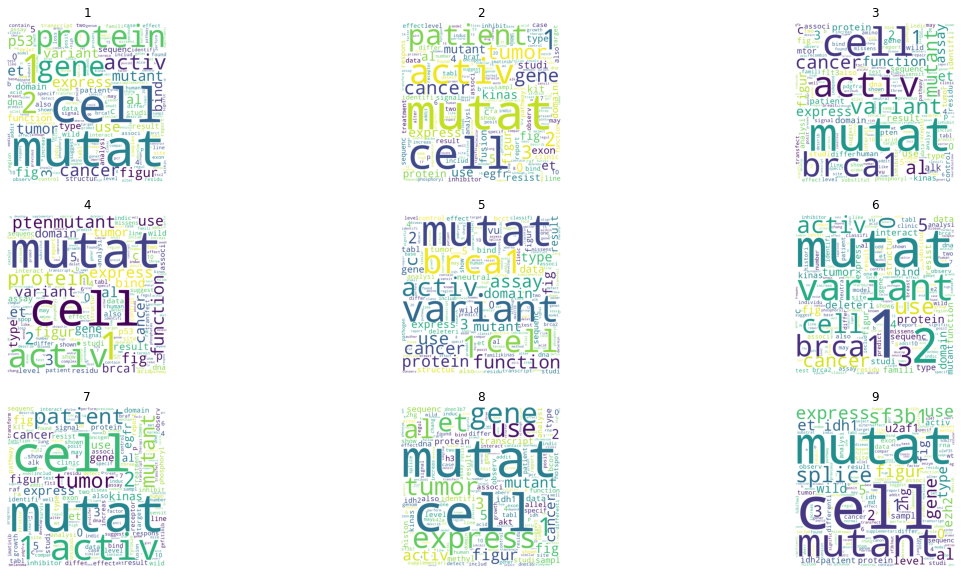

In [20]:
plota_wordcloud(word_cloud_plot,df_training,bag_words_corpus)

As palavras:
* mutat;
* cell;
* active
* números isolados;

parecem estar em todos as classes 

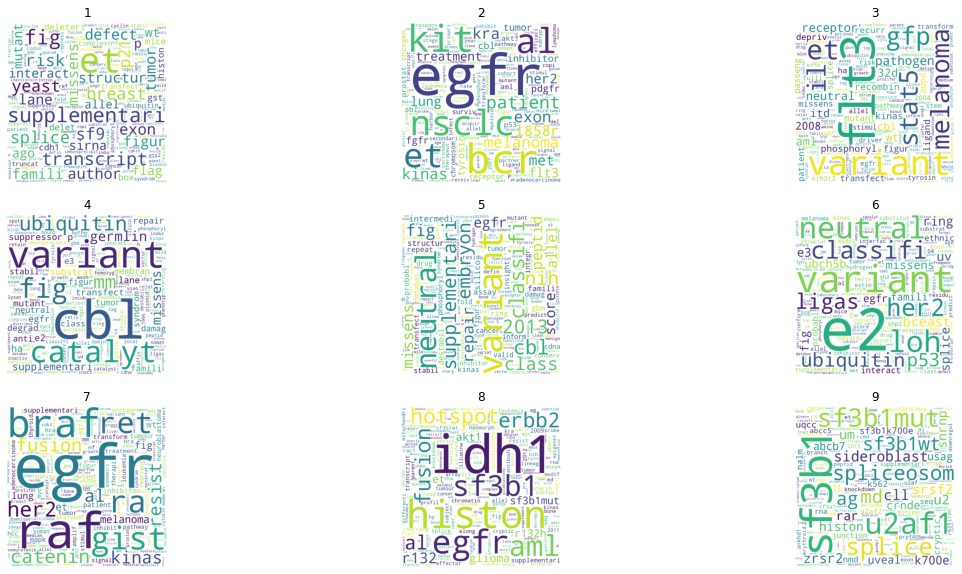

In [194]:
#Vamos ver se há diferença na nuvem de palavras usando o conceito de TF-IDF
plota_wordcloud(word_cloud_plot_tfidf,df_training,tfidf)

Quando usamos tf-idf, as palavras que aparecem tm toda são:
* fig: referencia a uma figura;
* et: referencia bibliografica;
* al: referencia bibliografica;

## Vamos criar um modelo base

In [4]:
#Dividindo os dados de treino e teste, para verificar o quao bom nosso modelo está
x_train,x_test,x_valid,y_train,y_test,y_valid = train_test_valid_split(df_training)

In [7]:
X,X_train,X_test,X_valid,Y_train,Y_test,Y_valid = dados_modelo_treino_valid(x_train,x_test,x_valid,df_training,dicionario,tfidf,N)

# Vamos verificar, se os dados Gene e Variation encontram-se nos respectivos textos

In [25]:
vetor_gene = []
vetor_variation = []
for (i,[gene,variation]) in enumerate(zip(df_training["Gene"],df_training["Variation"])):
    try:
        if(X[i,dicionario[gene.lower()]]>0):
            vetor_gene.append(True)
        else:
            vetor_gene.append(False)
    except:
        vetor_gene.append(False)
    
    try:
        if(X[i,dicionario[variation.lower()]]>0):
            vetor_variation.append(True)
        else:
            vetor_variation.append(False)
    except:
        vetor_variation.append(False)

Alguns documentos não possuem a informação de gene e variation, conforme está no dataset

In [11]:
pd.Series(vetor_variation).value_counts()

True     1817
False    1504
dtype: int64

In [12]:
pd.Series(vetor_gene).value_counts()

True     2985
False     336
dtype: int64

## Criando a rede neural para o treinamento - Modelo 1

In [13]:
X_train.shape

TensorShape([1859, 164493])

In [ ]:
#Criando o modelo para receber os dados de entrada
camada_entrada = Input(shape = (X.shape[1],), sparse=True,name = "Camada_Entrada")
primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)
segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)
camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo1 = Model(inputs = [camada_entrada], outputs = [camada_saida])
#modelo1.add(Dense(100,activation = 'relu',kernel_initializer = 'uniform'))
#modelo1.add(Dense(9,activation = 'softmax',kernel_initializer = 'uniform'))

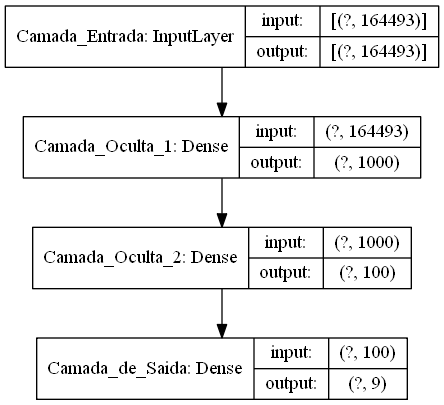

In [9]:
#Visualizando o primeiro modelo
plot_model(modelo1,show_shapes=True)

In [10]:
modelo1.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

In [11]:
modelo1 = start_training(X_train=X_train,X_valid=X_valid,Y_train=Y_train,Y_valid=Y_valid,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo1", modelo= modelo1)

Epoch 1/150
93/93 [==============================] - 19s 204ms/step - loss: 1.8990 - categorical_accuracy: 0.2781 - auc: 0.7420 - val_loss: 1.8410 - val_categorical_accuracy: 0.2860 - val_auc: 0.7575
Epoch 2/150
93/93 [==============================] - 6s 66ms/step - loss: 1.8390 - categorical_accuracy: 0.2813 - auc: 0.7553 - val_loss: 1.8415 - val_categorical_accuracy: 0.2860 - val_auc: 0.7578
Epoch 3/150
93/93 [==============================] - 19s 205ms/step - loss: 1.8398 - categorical_accuracy: 0.2873 - auc: 0.7551 - val_loss: 1.8367 - val_categorical_accuracy: 0.2860 - val_auc: 0.7550
Epoch 4/150
93/93 [==============================] - 19s 203ms/step - loss: 1.8359 - categorical_accuracy: 0.2824 - auc: 0.7572 - val_loss: 1.8336 - val_categorical_accuracy: 0.2860 - val_auc: 0.7579
Epoch 5/150
93/93 [==============================] - 6s 66ms/step - loss: 1.8361 - categorical_accuracy: 0.2873 - auc: 0.7564 - val_loss: 1.8373 - val_categorical_accuracy: 0.2860 - val_auc: 0.7569
Epoc

## Criando outro check point

In [5]:
reset_keras()

499


In [ ]:
modelo1 = load_model("./modelos/modelo1.hdf5")
modelo1_history = json.load(open("./modelos/history_modelo1.json",'r'))

In [6]:
tfidf = pickle.load(open("tfidf.plk","rb"))
tf_treino = pickle.load(open("tf_treino.plk","rb"))
idf_treino = pickle.load(open("idf_treino.plk","rb"))
DocFreq = pickle.load(open("DocFreq.plk","rb"))
bag_words_corpus = pickle.load(open("bag_of_words.plk","rb"))
listagem = pickle.load(open("listagem.pkl","rb"))
dicionario = pickle.load(open("dicionario.pkl","rb"))

df_training = pd.read_csv("df_training.csv")

N = len(bag_words_corpus)

x_train,x_test,x_valid,y_train,y_test,y_valid = train_test_valid_split(df_treino=  df_training)

In [24]:
X,X_train,X_test,X_valid,Y_train,Y_test,Y_valid = dados_modelo_treino_valid(x_train,x_test,x_valid,df_training,dicionario,tfidf,N)

## Verificando o Modelo 1

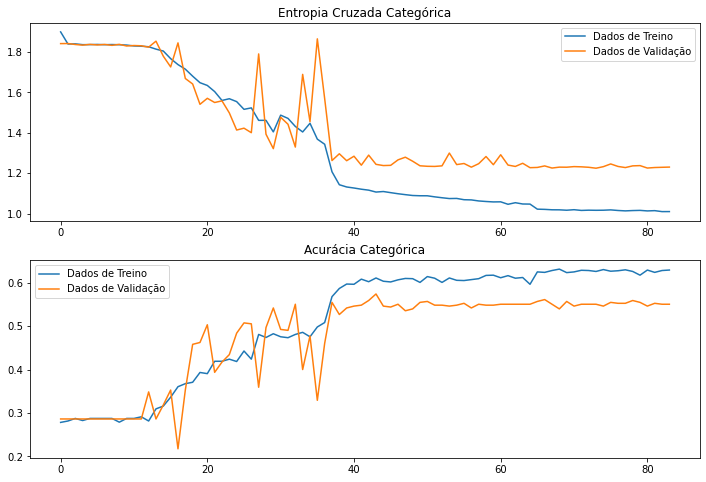

In [7]:
plot_treinamento(modelo1_history)

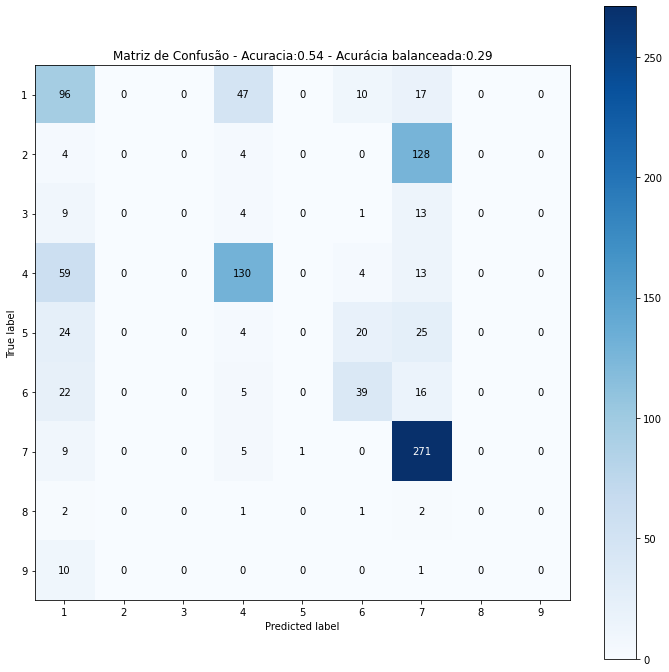

In [22]:
#Há muitos problemas com a classe 2, 5, 8 e 9 (estas últimas pela quantidade de amostras)
plot_matriz_confusao(modelo1,X_test,Y_test)

In [10]:
balanced_accuracy_score(y_pred=tf.argmax(modelo1.predict(X_test), axis = 1)+1,
                                    y_true=Y_test.argmax(axis=1)+1)

0.2909928941297776

In [11]:
accuracy_score(y_pred=tf.argmax(modelo1.predict(X_test), axis = 1)+1,
                                    y_true=Y_test.argmax(axis=1)+1)

0.5376128385155466

### Tentativa de melhora do modelo - remover palavras que são comuns a todas as classes - Modelo 2

In [7]:
palavras_comuns = ['fig','et','al','mutat','cell','activ','0','1','2','3','4','5','6','7','8','9']
palavras_comuns

['fig',
 'et',
 'al',
 'mutat',
 'cell',
 'activ',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [8]:
listagem_nova,bag_of_words_novo,dicionario_novo,N_novo,DocFreq_novo,tf_novo,idf_novo,tfidf_novo = remove_palavras(listagem,
                                                                                                                  bag_words_corpus,
                                                                                                                  palavras_comuns)

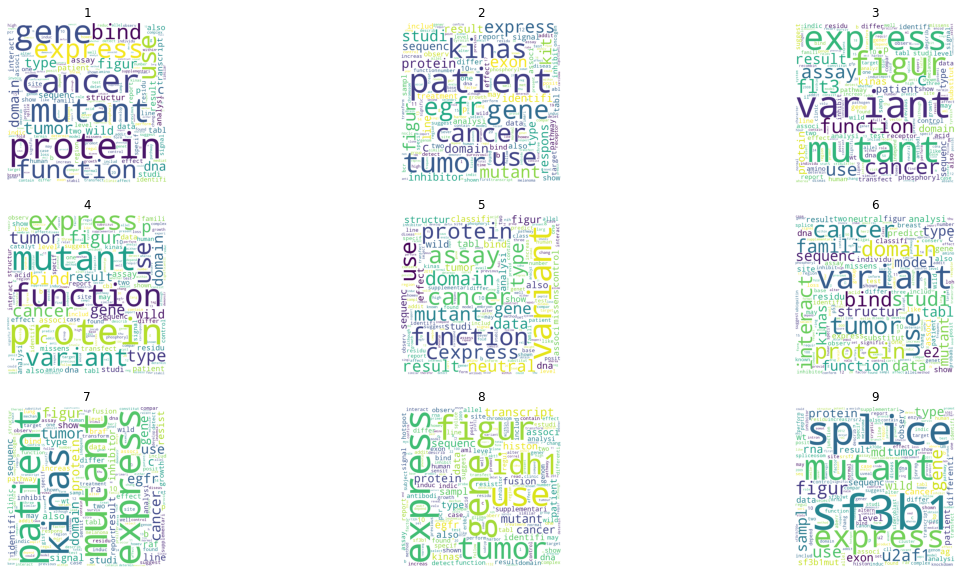

In [76]:
#Verificando a nuvem de palavras, usando TF-IDF, com a nova listagem
plota_wordcloud(word_cloud_plot_tfidf,
                df_training,tfidf_novo)

In [72]:
pickle.dump(tfidf_novo,open("tfidf_novo.plk","wb"))
pickle.dump(tf_novo,open("tf_novo.plk","wb"))
pickle.dump(idf_novo,open("idf_novo.plk","wb"))
pickle.dump(DocFreq_novo,open("DocFreq_novo.plk","wb"))
pickle.dump(bag_of_words_novo,open("bag_of_words_novo.plk","wb"))
pickle.dump(listagem_nova,open("listagem_nova.pkl","wb"))
pickle.dump(dicionario_novo,open("dicionario_novo.pkl","wb"))

In [16]:
tfidf_novo=pickle.load(open("tfidf_novo.plk","rb"))
#tf_novo=pickle.load(open("tf_novo.plk","rb"))
#idf_novo = pickle.load(open("idf_novo.plk","rb"))
DocFreq_novo = pickle.load(open("DocFreq_novo.plk","rb"))
bag_of_words_novo = pickle.load(open("bag_of_words_novo.plk","rb"))
listagem_nova=pickle.load(open("listagem_nova.pkl","rb"))
dicionario_novo=pickle.load(open("dicionario_novo.pkl","rb"))

In [7]:
# Gerando segundo modelo
N_novo = len(bag_of_words_novo)
X_novo,X_train_novo,X_test_novo,X_valid_novo,Y_train_novo,Y_test_novo,Y_valid_novo  = dados_modelo_treino_valid(x_train,x_test,x_valid,
                                                                                                                df_training,dicionario_novo,
                                                                                                                tfidf_novo,N_novo)

In [8]:
reset_keras()

477


In [12]:
camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo2 = Model(inputs = [camada_entrada], outputs = [camada_saida])

In [17]:
modelo2.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

In [18]:
modelo2 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo2", modelo= modelo2)

Epoch 1/150
93/93 [==============================] - 20s 217ms/step - loss: 1.8990 - categorical_accuracy: 0.2797 - auc: 0.7413 - val_loss: 1.8328 - val_categorical_accuracy: 0.2860 - val_auc: 0.7661
Epoch 2/150
93/93 [==============================] - 19s 204ms/step - loss: 1.8349 - categorical_accuracy: 0.2867 - auc: 0.7579 - val_loss: 1.8258 - val_categorical_accuracy: 0.2860 - val_auc: 0.7810
Epoch 3/150
93/93 [==============================] - 19s 205ms/step - loss: 1.8046 - categorical_accuracy: 0.3093 - auc: 0.7718 - val_loss: 1.7480 - val_categorical_accuracy: 0.2903 - val_auc: 0.8082
Epoch 4/150
93/93 [==============================] - 19s 201ms/step - loss: 1.6240 - categorical_accuracy: 0.4217 - auc: 0.8295 - val_loss: 1.4885 - val_categorical_accuracy: 0.4581 - val_auc: 0.8646
Epoch 5/150
93/93 [==============================] - 19s 204ms/step - loss: 1.4845 - categorical_accuracy: 0.4508 - auc: 0.8585 - val_loss: 1.4049 - val_categorical_accuracy: 0.4882 - val_auc: 0.8733


## Verificando o modelo 2

In [9]:
modelo2 = load_model("./modelos/modelo2.hdf5")
modelo2_history = json.load(open("./modelos/history_modelo2.json",'r'))

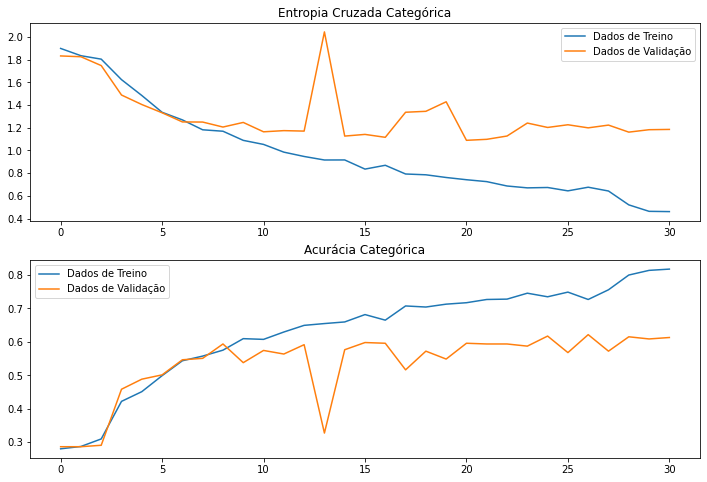

In [10]:
plot_treinamento(modelo2_history)

__Nota-se que houve uma melhora no resultado do modelo__

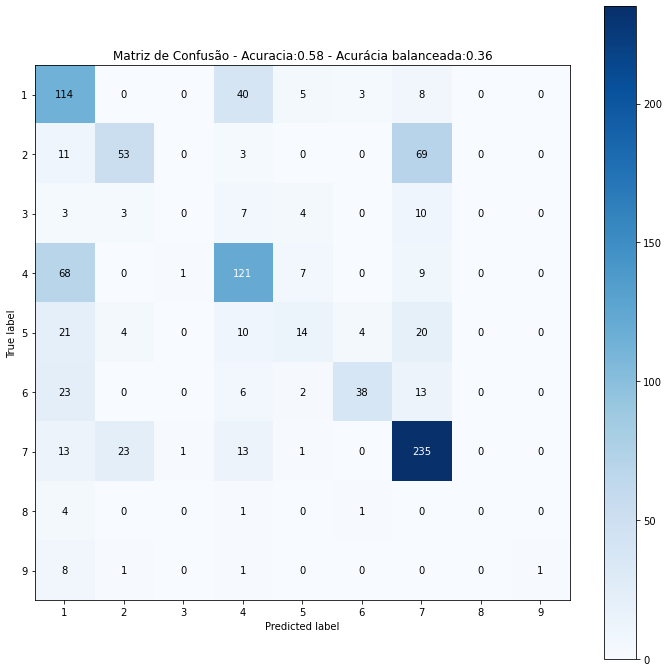

In [11]:
plot_matriz_confusao(modelo2,X_test_novo,Y_test_novo)

## Tentativa de melhora do modelo - remover palavras com pouca frequencia - Modelo 3

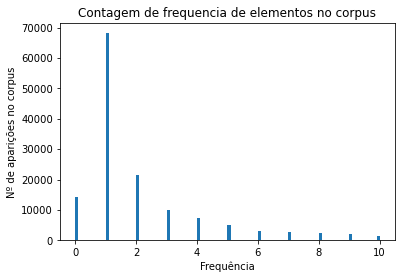

In [29]:
contagem_frequencia = np.array([valor for chave,valor in DocFreq_novo.items()])
plt.hist(contagem_frequencia[contagem_frequencia <= 10], bins = 100)
plt.title("Contagem de frequencia de elementos no corpus")
plt.xlabel("Frequência")
plt.ylabel("Nº de aparições no corpus")
plt.show()

In [30]:
palavras_remover2 = [chave for chave,valor in DocFreq_novo.items() if valor <= 1]
len(palavras_remover2)

82493

In [34]:
listagem_nova,bag_of_words_novo,dicionario_novo,N_novo,DocFreq_novo,tf_novo,idf_novo,tfidf_novo = remove_palavras(listagem_nova,
                                                                                                                  bag_of_words_novo,
                                                                                                                  palavras_remover2)

Listagem nova concluida
BOW concluído
Dicionário novo concluído
DoqFreq novo concluído
TF e IDF novos concluídos
TFIDF novo concluído


In [27]:
pickle.dump(tfidf_novo,open("tfidf_novo.plk","wb"))
pickle.dump(tf_novo,open("tf_novo.plk","wb"))
pickle.dump(idf_novo,open("idf_novo.plk","wb"))
pickle.dump(DocFreq_novo,open("DocFreq_novo.plk","wb"))
pickle.dump(bag_of_words_novo,open("bag_of_words_novo.plk","wb"))
pickle.dump(listagem_nova,open("listagem_nova.pkl","wb"))
pickle.dump(dicionario_novo,open("dicionario_novo.pkl","wb"))

In [7]:
tfidf_novo=pickle.load(open("tfidf_novo.plk","rb"))
#tf_novo=pickle.load(open("tf_novo.plk","rb"))
#idf_novo = pickle.load(open("idf_novo.plk","rb"))
DocFreq_novo = pickle.load(open("DocFreq_novo.plk","rb"))
bag_of_words_novo = pickle.load(open("bag_of_words_novo.plk","rb"))
listagem_nova=pickle.load(open("listagem_nova.pkl","rb"))
dicionario_novo=pickle.load(open("dicionario_novo.pkl","rb"))

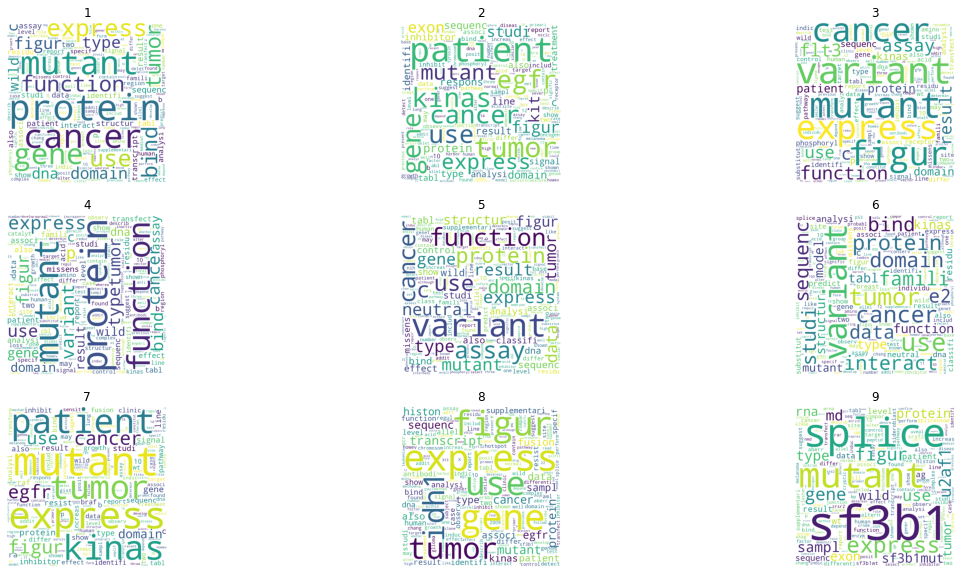

In [98]:
#Verificando a nuvem de palavras, usando TF-IDF, com a nova listagem
plota_wordcloud(word_cloud_plot_tfidf,
                df_training,tfidf_novo)

In [ ]:
# Gerando terceiro modelo
N_novo = len(bag_of_words_novo)
X_novo,X_train_novo,X_test_novo,X_valid_novo,Y_train_novo,Y_test_novo,Y_valid_novo  = dados_modelo_treino_valid(x_train,x_test,x_valid,
                                                                                                                df_training,dicionario_novo,
                                                                                                                tfidf_novo,N_novo)

In [100]:
reset_keras()

41079


In [30]:
camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo3 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo3.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo3 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo3", modelo= modelo3)

## Verificando o modelo 3

In [47]:
modelo3 = load_model("./modelos/modelo3.hdf5")

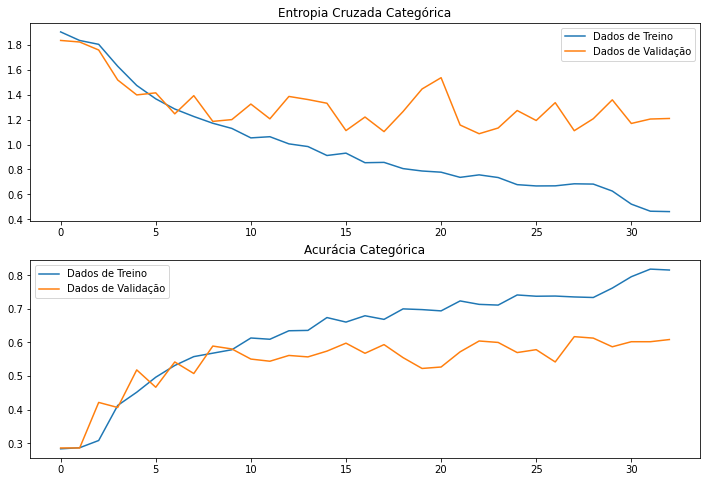

In [48]:
modelo3_history = json.load(open("./modelos/history_modelo3.json",'r'))
plot_treinamento(modelo3_history)

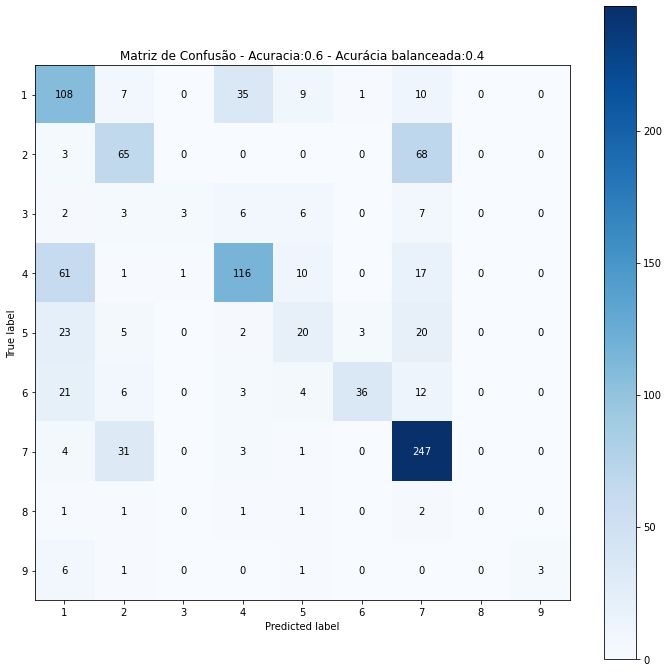

In [49]:
plot_matriz_confusao(modelo3,X_test_novo,Y_test_novo)

#### Removendo palavras com 2 ocorrencias - Modelo 4

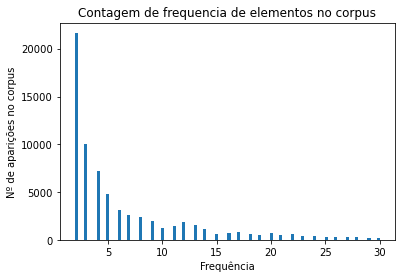

In [57]:
contagem_frequencia = np.array([valor for chave,valor in DocFreq_novo.items()])
plt.hist(contagem_frequencia[contagem_frequencia <= 30], bins = 100)
plt.title("Contagem de frequencia de elementos no corpus")
plt.xlabel("Frequência")
plt.ylabel("Nº de aparições no corpus")
plt.show()

In [64]:
palavras_remover3 = [chave for chave,valor in DocFreq_novo.items() if valor <= 2]
len(palavras_remover3)

21605

In [65]:
listagem_nova,bag_of_words_novo,dicionario_novo,N_novo,DocFreq_novo,tf_novo,idf_novo,tfidf_novo = remove_palavras(listagem_nova,
                                                                                                                  bag_of_words_novo,
                                                                                                                  palavras_remover3)

Conjunto de palavras a remover concluído
Listagem nova concluida
BOW concluído
Dicionário novo concluído
DoqFreq novo concluído
TF e IDF novos concluídos
TFIDF novo concluído


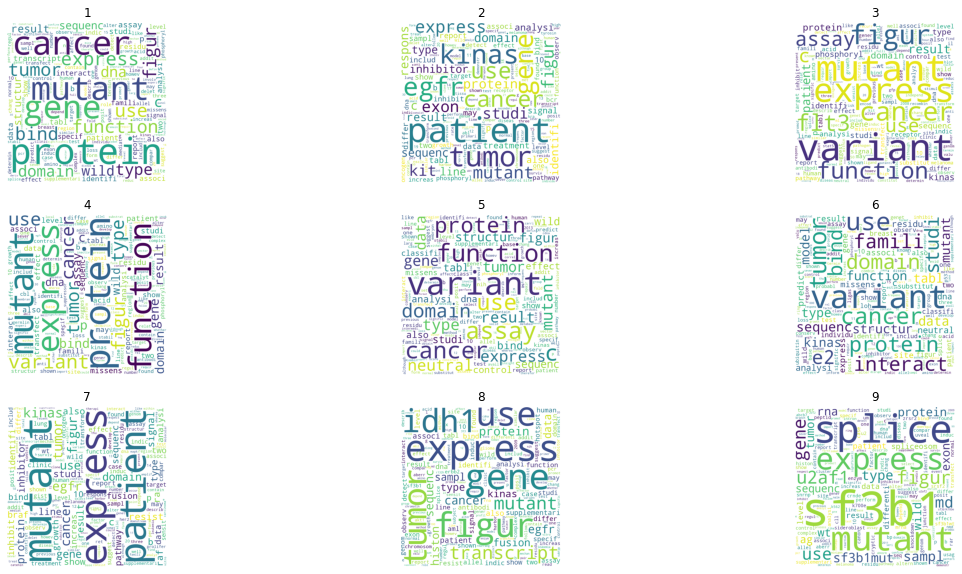

In [66]:
#Verificando a nuvem de palavras, usando TF-IDF, com a nova listagem
plota_wordcloud(word_cloud_plot_tfidf,
                df_training,tfidf_novo)

In [11]:
# Gerando quarto modelo
N_novo = len(bag_of_words_novo)
X_novo,X_train_novo,X_test_novo,X_valid_novo,Y_train_novo,Y_test_novo,Y_valid_novo  = dados_modelo_treino_valid(x_train,x_test,x_valid,
                                                                                                                df_training,dicionario_novo,
                                                                                                                tfidf_novo,N_novo)

In [8]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo4 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo4.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo4 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo4", modelo= modelo4)

## Verificando o modelo 4

In [5]:
modelo4 = load_model("./modelos/modelo4.hdf5")
modelo4_history = json.load(open("./modelos/history_modelo4.json",'r'))

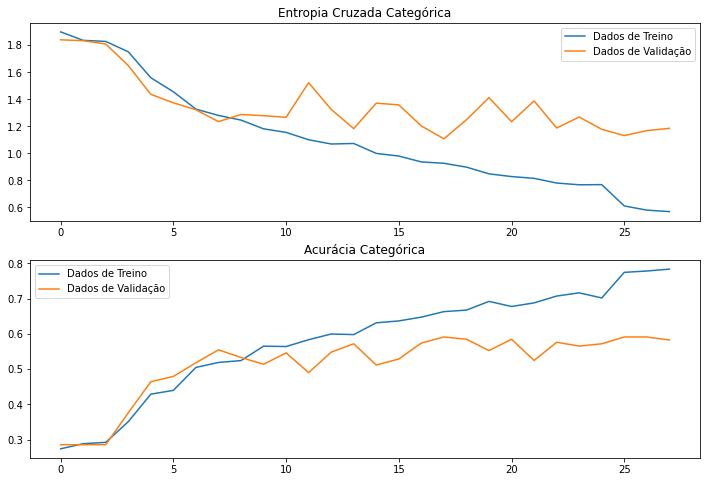

In [6]:
plot_treinamento(modelo4_history)

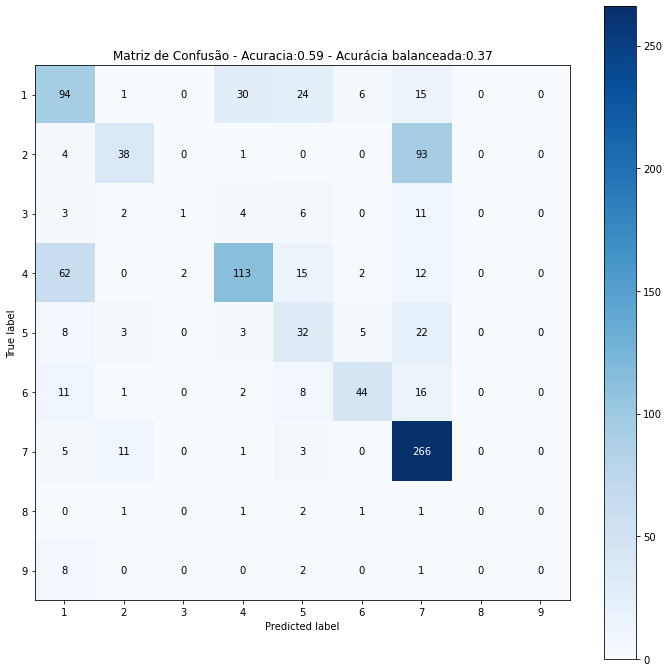

In [75]:
plot_matriz_confusao(modelo4,X_test_novo,Y_test_novo)

O modelo 4 não apresentou melhoras, comparado ao modelo 3

## Tentativa de melhora do modelo - inserindo palavras que faltam que existem no dataframe - Modelo 5

Algumas palavras, que estão no dataset de treino, não estão no Texto

In [53]:
corpus_variation = [corpusnization(token) for token in df_training.Variation.tolist()]
corpus_gene = [corpusnization(token) for token in df_training.Gene.tolist()]

In [ ]:
gene_faltante = []
variation_faltante = []
for (i,[gene,variation]) in enumerate(zip(corpus_gene,corpus_variation)):
    for cada_gene in gene:
        try:
            DocFreq[cada_gene]

## Criação de bigramas - uma nova abordagem

Vamos criar bigramas e verificar se eles são mais eficazes ao modelo

In [73]:
metricas_bigramas = BigramAssocMeasures()

In [10]:
colecao_bigramas = [BigramCollocationFinder.from_words(doc) for doc in treino_corpus]

In [37]:
#Vamos filtrar a colecao de bigramas para remover bigramas que contenha fora da listagem
for doc in colecao_bigramas:
    doc.apply_ngram_filter(lambda p1,p2: False if((p1 in listagem_nova) & (p2 in listagem_nova)) else True)


In [39]:
pickle.dump(colecao_bigramas,open("bigramas_filtrada.plk","wb"))

In [4]:
colecao_bigramas=pickle.load(open("bigramas_filtrada.plk","rb"))

In [64]:
for doc in colecao_bigramas:
    doc.apply_freq_filter(min_freq=10)
    doc.apply_ngram_filter(lambda p1,p2: True if((p1 == "wild") & (p2 == "type")) else False)

In [65]:
list_frequencia_bigrama = []
for doc in colecao_bigramas:
    dict_aux = {}
    for chave,valor in dict(doc.ngram_fd).items():
        dict_aux.update({"".join((chave[0],"_",chave[1])): valor})
    list_frequencia_bigrama.append(dict_aux)

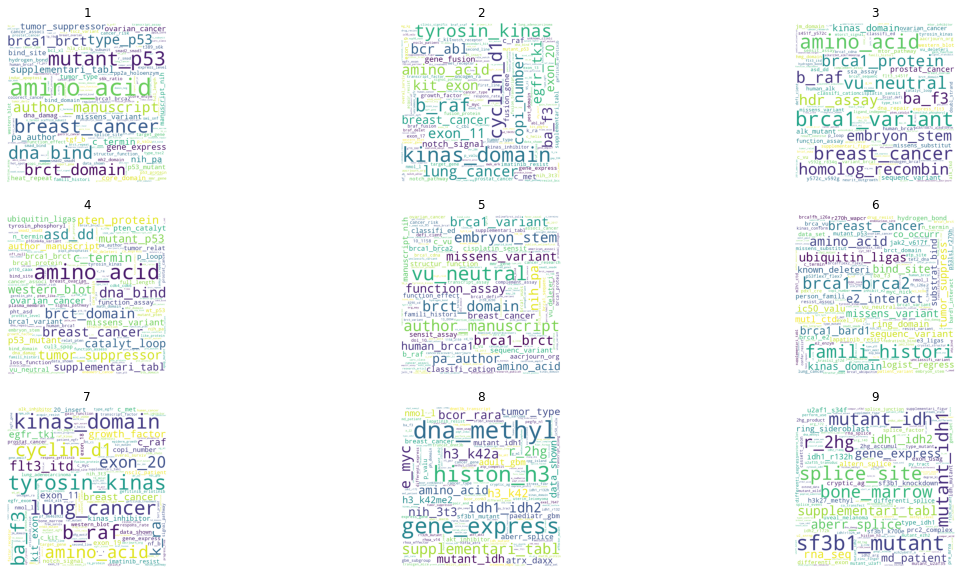

In [66]:
plota_wordcloud(word_cloud_plot,
                df_training,list_frequencia_bigrama)

In [90]:
N_novo = len(list_frequencia_bigrama)
X_novo,X_train_novo,X_test_novo,X_valid_novo,Y_train_novo,Y_test_novo,Y_valid_novo  = dados_modelo_treino_valid(x_train,
                                                                                                                x_test,
                                                                                                                x_valid,
                                                                                                                df_training,
                                                                                                                cria_dicionario_palavras( cria_listagem_palavras(list_frequencia_bigrama)),
                                                                                                                list_frequencia_bigrama,
                                                                                                                N_novo)

In [94]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo5 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo5.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo5 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo5", modelo= modelo5)

19073
Epoch 1/150
93/93 [==============================] - 7s 78ms/step - loss: 2.1013 - categorical_accuracy: 0.2899 - auc: 0.7374 - val_loss: 1.8241 - val_categorical_accuracy: 0.3011 - val_auc: 0.7682
Epoch 2/150
93/93 [==============================] - 4s 41ms/step - loss: 1.8035 - categorical_accuracy: 0.3012 - auc: 0.7664 - val_loss: 1.8183 - val_categorical_accuracy: 0.3011 - val_auc: 0.7680
Epoch 3/150
93/93 [==============================] - 3s 27ms/step - loss: 1.8014 - categorical_accuracy: 0.3018 - auc: 0.7657 - val_loss: 1.8188 - val_categorical_accuracy: 0.3011 - val_auc: 0.7682
Epoch 4/150
93/93 [==============================] - 3s 29ms/step - loss: 1.7997 - categorical_accuracy: 0.3018 - auc: 0.7663 - val_loss: 1.8212 - val_categorical_accuracy: 0.3011 - val_auc: 0.7682
Epoch 5/150
93/93 [==============================] - 3s 36ms/step - loss: 1.7997 - categorical_accuracy: 0.3018 - auc: 0.7671 - val_loss: 1.8170 - val_categorical_accuracy: 0.3011 - val_auc: 0.7682
Epoc

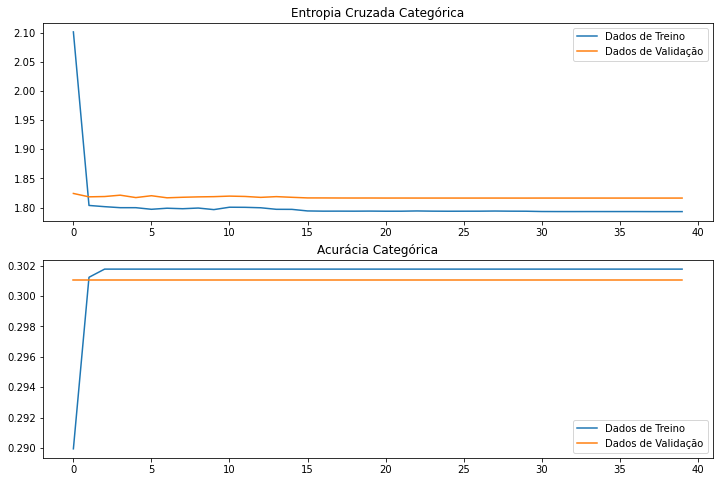

In [95]:
modelo5_history = json.load(open("./modelos/history_modelo5.json",'r'))
plot_treinamento(modelo5_history)

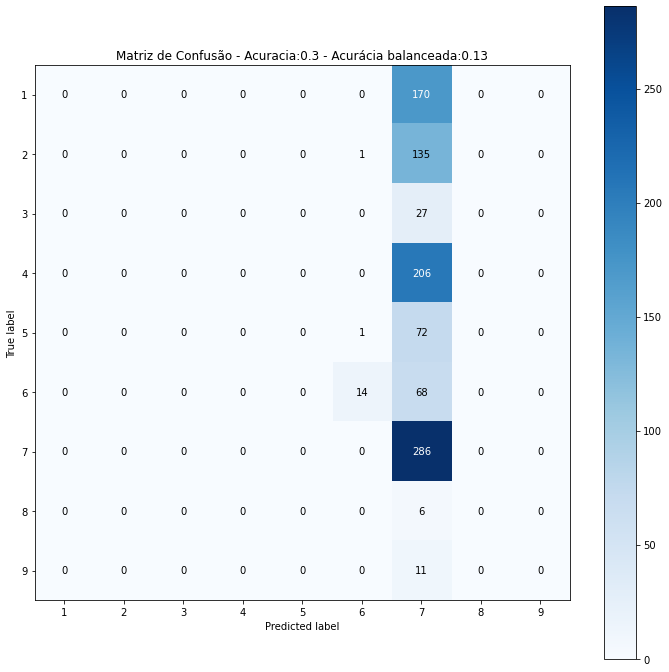

In [96]:
plot_matriz_confusao(modelo5,X_test_novo,Y_test_novo)

Este foi o pior modelo até o momento

In [80]:
#Tentando usar PMI
list_frequencia_bigrama_PMI = []
for doc in colecao_bigramas:
    dict_aux = {}
    for chave,valor in dict(doc.score_ngrams(metricas_bigramas.pmi)).items():
        dict_aux.update({"".join((chave[0],"_",chave[1])): valor})
    list_frequencia_bigrama_PMI.append(dict_aux)

In [ ]:
X_novo,X_train_novo,X_test_novo,X_valid_novo,Y_train_novo,Y_test_novo,Y_valid_novo  = dados_modelo_treino_valid(x_train,
                                                                                                                x_test,
                                                                                                                x_valid,
                                                                                                                df_training,
                                                                                                                cria_dicionario_palavras( cria_listagem_palavras(list_frequencia_bigrama_PMI)),
                                                                                                                list_frequencia_bigrama_PMI,
                                                                                                                N_novo)

In [87]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(1000,activation = 'relu',kernel_initializer = 'uniform',
                               kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=regularizers.l2(1e-4),
                               activity_regularizer=regularizers.l2(1e-5),
                               name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',
                              kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),
                              activity_regularizer=regularizers.l2(1e-5),
                              name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo6 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo6.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo6 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo6", modelo= modelo6)

346
Epoch 1/150
93/93 [==============================] - 11s 119ms/step - loss: 6.9546 - categorical_accuracy: 0.4454 - auc: 0.8443 - val_loss: 6.7617 - val_categorical_accuracy: 0.4903 - val_auc: 0.8694
Epoch 2/150
93/93 [==============================] - 8s 82ms/step - loss: 6.4326 - categorical_accuracy: 0.6025 - auc: 0.9178 - val_loss: 6.7511 - val_categorical_accuracy: 0.5398 - val_auc: 0.8662
Epoch 3/150
93/93 [==============================] - 7s 80ms/step - loss: 6.1302 - categorical_accuracy: 0.6708 - auc: 0.9372 - val_loss: 6.5257 - val_categorical_accuracy: 0.5677 - val_auc: 0.8770
Epoch 4/150
93/93 [==============================] - 8s 83ms/step - loss: 5.8538 - categorical_accuracy: 0.7364 - auc: 0.9529 - val_loss: 6.3793 - val_categorical_accuracy: 0.5097 - val_auc: 0.8806
Epoch 5/150
93/93 [==============================] - 6s 65ms/step - loss: 5.8042 - categorical_accuracy: 0.7203 - auc: 0.9494 - val_loss: 6.7296 - val_categorical_accuracy: 0.5097 - val_auc: 0.8537
Epoc

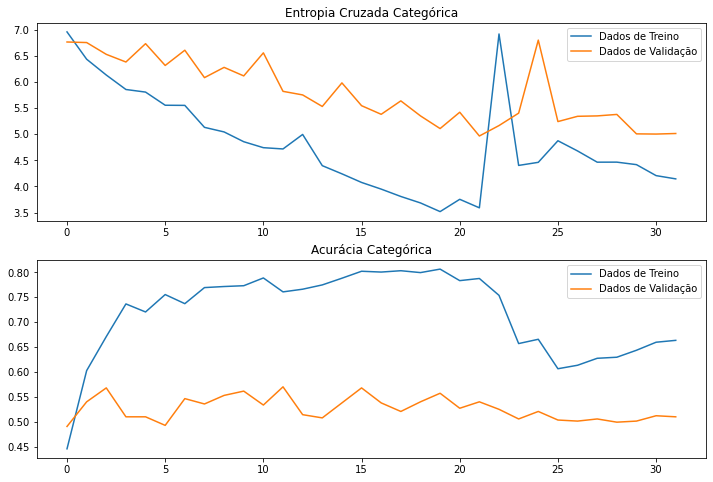

In [88]:
modelo6_history = json.load(open("./modelos/history_modelo6.json",'r'))
plot_treinamento(modelo6_history)

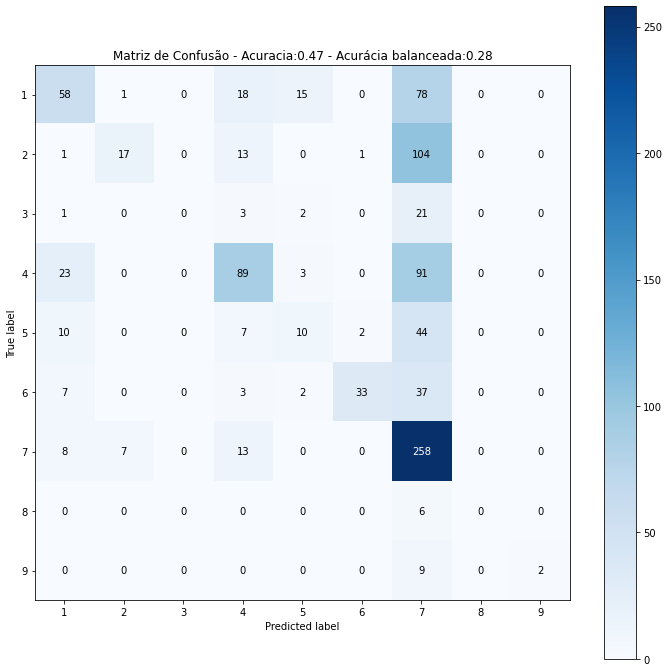

In [89]:
plot_matriz_confusao(modelo6,X_test_novo,Y_test_novo)

## Pegando o melhor modelo (modelo 3) e verificando se, alterando a estrutura da rede e aplicando regularização, podemos obter melhorias

#### 1 - incluindo regularização no modelo e reduzindo a quantidade de neuronios na camada de entrada

Houve uma necessidade de redução de neurônios por conta da limitação do hardware

In [110]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(500,activation = 'relu',kernel_initializer = 'uniform',
                               kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=regularizers.l2(1e-4),
                               activity_regularizer=regularizers.l2(1e-5),
                               name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(100,activation = 'relu',kernel_initializer = 'uniform',
                              kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),
                              activity_regularizer=regularizers.l2(1e-5),
                              name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo3_1 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo3_1.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo3_1 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo3_1", modelo= modelo3_1)

107
Epoch 1/150
93/93 [==============================] - 14s 146ms/step - loss: 15.3951 - categorical_accuracy: 0.2803 - auc: 0.7404 - val_loss: 15.1153 - val_categorical_accuracy: 0.2860 - val_auc: 0.7577
Epoch 2/150
93/93 [==============================] - 10s 111ms/step - loss: 14.9029 - categorical_accuracy: 0.2803 - auc: 0.7559 - val_loss: 14.6782 - val_categorical_accuracy: 0.2860 - val_auc: 0.7686
Epoch 3/150
93/93 [==============================] - 10s 113ms/step - loss: 14.4691 - categorical_accuracy: 0.2878 - auc: 0.7586 - val_loss: 14.2508 - val_categorical_accuracy: 0.2860 - val_auc: 0.7790
Epoch 4/150
93/93 [==============================] - 10s 110ms/step - loss: 14.0381 - categorical_accuracy: 0.2985 - auc: 0.7654 - val_loss: 13.7924 - val_categorical_accuracy: 0.2860 - val_auc: 0.7890
Epoch 5/150
93/93 [==============================] - 10s 113ms/step - loss: 13.5015 - categorical_accuracy: 0.3808 - auc: 0.8121 - val_loss: 13.1636 - val_categorical_accuracy: 0.4495 - va

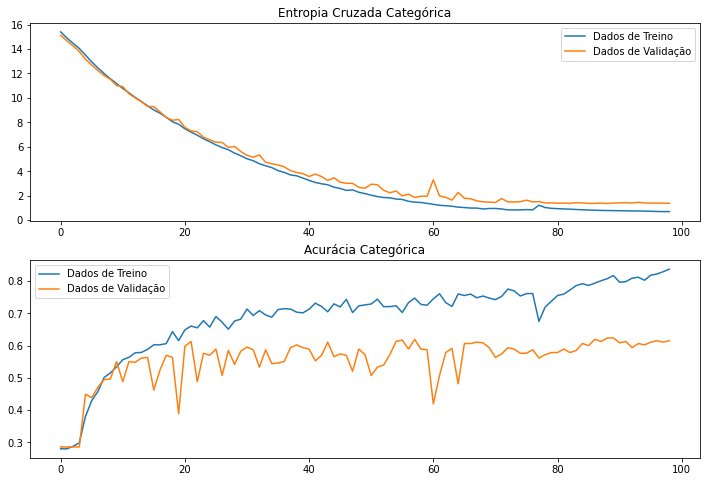

In [111]:
modelo3_1_history = json.load(open("./modelos/history_modelo3_1.json",'r'))
plot_treinamento(modelo3_1_history)

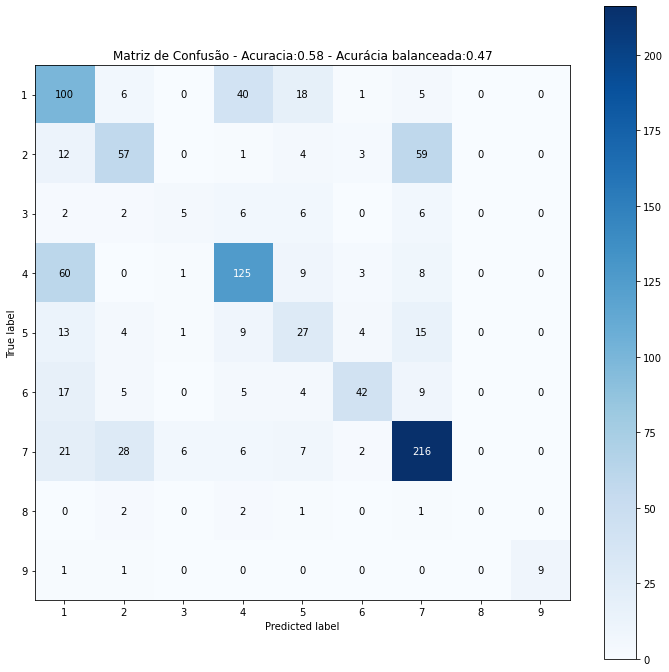

In [51]:
plot_matriz_confusao(modelo3_1,X_test_novo,Y_test_novo)

Houve uma aparente melhora em relação ao modelo 3 original

#### 2 - incluindo regularização no modelo e reduzindo ainda mais a quantidade de neuronios na camada de entrada

In [114]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(300,activation = 'relu',kernel_initializer = 'uniform',
                               kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=regularizers.l2(1e-4),
                               activity_regularizer=regularizers.l2(1e-5),
                               name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(50,activation = 'relu',kernel_initializer = 'uniform',
                              kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),
                              activity_regularizer=regularizers.l2(1e-5),
                              name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo3_2 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo3_2.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo3_2 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo3_2", modelo= modelo3_2)

3217
Epoch 1/150
93/93 [==============================] - 8s 89ms/step - loss: 10.0001 - categorical_accuracy: 0.2813 - auc: 0.7386 - val_loss: 9.8026 - val_categorical_accuracy: 0.2860 - val_auc: 0.7532
Epoch 2/150
93/93 [==============================] - 6s 68ms/step - loss: 9.6720 - categorical_accuracy: 0.2873 - auc: 0.7563 - val_loss: 9.5433 - val_categorical_accuracy: 0.2860 - val_auc: 0.7520
Epoch 3/150
93/93 [==============================] - 6s 65ms/step - loss: 9.4168 - categorical_accuracy: 0.2873 - auc: 0.7558 - val_loss: 9.2881 - val_categorical_accuracy: 0.2860 - val_auc: 0.7612
Epoch 4/150
93/93 [==============================] - 6s 66ms/step - loss: 9.1628 - categorical_accuracy: 0.2835 - auc: 0.7581 - val_loss: 9.0418 - val_categorical_accuracy: 0.2860 - val_auc: 0.7584
Epoch 5/150
93/93 [==============================] - 6s 68ms/step - loss: 8.9174 - categorical_accuracy: 0.2873 - auc: 0.7581 - val_loss: 8.7937 - val_categorical_accuracy: 0.2860 - val_auc: 0.7701
Epoc

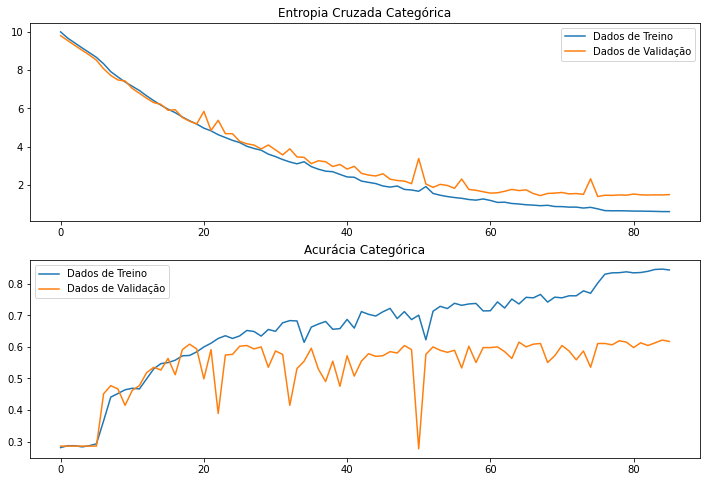

In [115]:
modelo3_2_history = json.load(open("./modelos/history_modelo3_2.json",'r'))
plot_treinamento(modelo3_2_history)

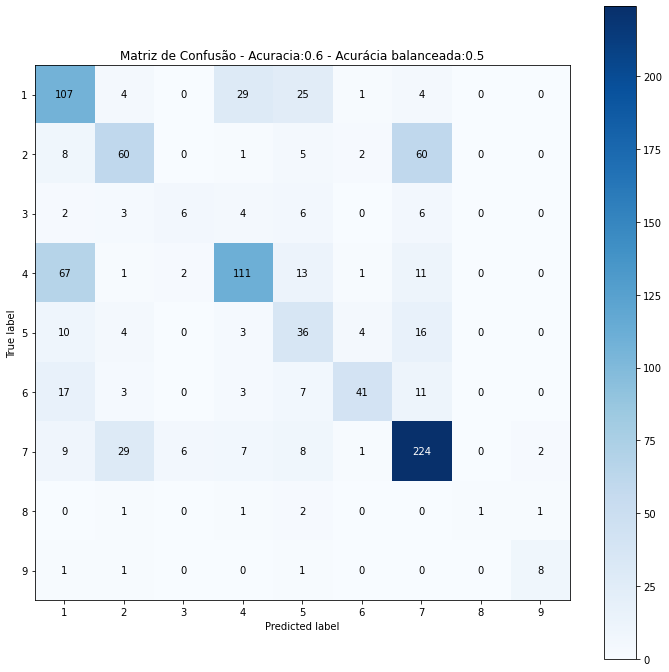

In [50]:
plot_matriz_confusao(modelo3_2,X_test_novo,Y_test_novo)

Houve melhora em relação ao modelo 3_1 

#### 3 - incluindo regularização no modelo e reduzindo ainda mais a quantidade de neuronios na camada de entrada

In [59]:
reset_keras()

camada_entrada = Input(shape = (X_novo.shape[1],), sparse=True,name = "Camada_Entrada")

primeira_camada_oculta = Dense(200,activation = 'relu',kernel_initializer = 'uniform',
                               kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=regularizers.l2(1e-4),
                               activity_regularizer=regularizers.l2(1e-5),
                               name = "Camada_Oculta_1")(camada_entrada)

segunda_camada_oculta = Dense(50,activation = 'relu',kernel_initializer = 'uniform',
                              kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),
                              activity_regularizer=regularizers.l2(1e-5),
                              name = "Camada_Oculta_2")(primeira_camada_oculta)

camada_saida = Dense(9,activation = 'softmax',kernel_initializer = 'uniform',name = "Camada_de_Saida")(segunda_camada_oculta)

modelo3_3 = Model(inputs = [camada_entrada], outputs = [camada_saida])

modelo3_3.compile(loss = 'categorical_crossentropy', 
                optimizer = SGD(lr = 0.05, momentum = 0.9, nesterov = True), 
                metrics = ['categorical_accuracy',AUC()])

modelo3_3 = start_training(X_train=X_train_novo,X_valid=X_valid_novo,Y_train=Y_train_novo,Y_valid=Y_valid_novo,
               saving_checkpoint_path="./modelos/", nome_modelo="modelo3_3", modelo= modelo3_3)

22803
Epoch 1/150
93/93 [==============================] - 6s 61ms/step - loss: 7.3022 - categorical_accuracy: 0.2792 - auc: 0.7401 - val_loss: 7.1532 - val_categorical_accuracy: 0.2860 - val_auc: 0.7532
Epoch 2/150
93/93 [==============================] - 4s 43ms/step - loss: 7.0633 - categorical_accuracy: 0.2873 - auc: 0.7548 - val_loss: 6.9707 - val_categorical_accuracy: 0.2860 - val_auc: 0.7618
Epoch 3/150
93/93 [==============================] - 4s 41ms/step - loss: 6.8900 - categorical_accuracy: 0.2873 - auc: 0.7556 - val_loss: 6.8038 - val_categorical_accuracy: 0.2860 - val_auc: 0.7619
Epoch 4/150
93/93 [==============================] - 4s 41ms/step - loss: 6.7238 - categorical_accuracy: 0.2873 - auc: 0.7546 - val_loss: 6.6376 - val_categorical_accuracy: 0.2860 - val_auc: 0.7592
Epoch 5/150
93/93 [==============================] - 4s 42ms/step - loss: 6.5589 - categorical_accuracy: 0.2781 - auc: 0.7565 - val_loss: 6.4735 - val_categorical_accuracy: 0.2860 - val_auc: 0.7630
Epoc

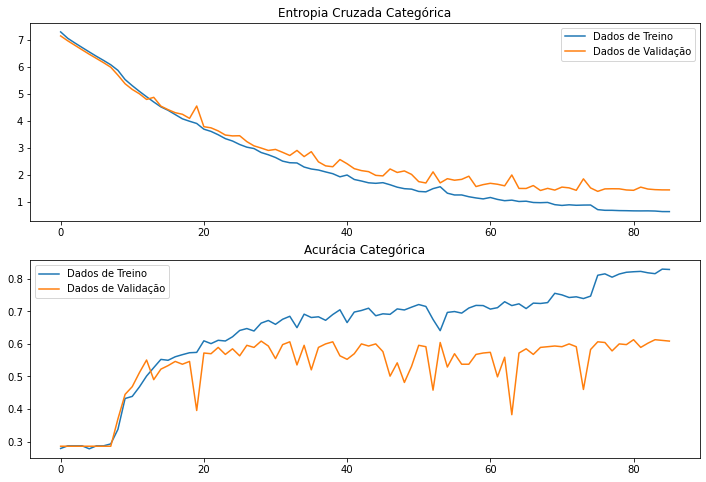

In [61]:
modelo3_3_history = json.load(open("./modelos/history_modelo3_3.json",'r'))
plot_treinamento(modelo3_3_history)

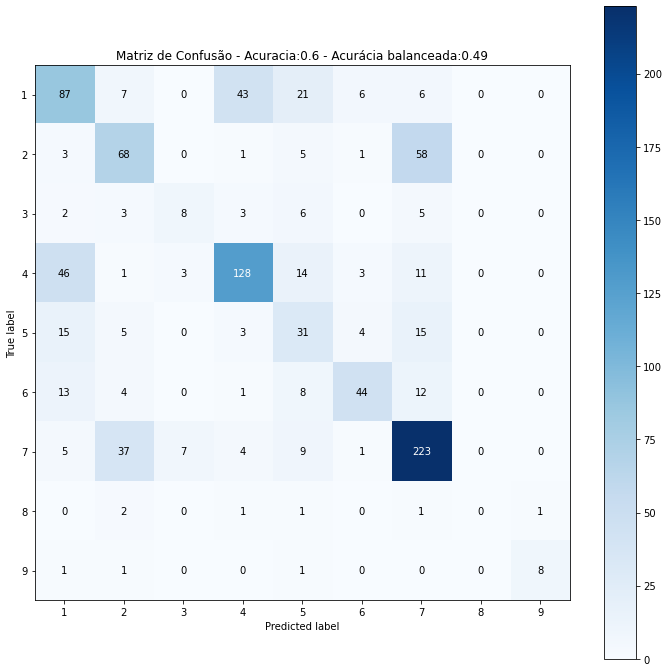

In [62]:
plot_matriz_confusao(modelo3_3,X_test_novo,Y_test_novo)

## Avaliando as versões do modelo 3 juntas

In [74]:
reset_keras()

129


In [75]:
modelo3 = load_model("./modelos/modelo3.hdf5")
modelo3_1 = load_model("./modelos/modelo3_1.hdf5")
modelo3_2 = load_model("./modelos/modelo3_2.hdf5")
modelo3_3 = load_model("./modelos/modelo3_3.hdf5")

In [79]:
scores_modelos3 =    {"Acuracia_balanceada":[balanced_accuracy_score(y_pred=tf.argmax(modelagem.predict(X_test_novo), axis = 1),
                                                                     y_true=Y_test_novo.argmax(axis=1)) for modelagem in 
                                              [modelo3,modelo3_1,modelo3_2,modelo3_3]], 
                       "Acuracia": [accuracy_score(y_pred=tf.argmax(modelagem.predict(X_test_novo), axis = 1),
                                                  y_true=Y_test_novo.argmax(axis=1)) for modelagem in 
                                              [modelo3,modelo3_1,modelo3_2,modelo3_3]],
                       "F1": [f1_score(y_pred=tf.argmax(modelagem.predict(X_test_novo), axis = 1),
                                      y_true=Y_test_novo.argmax(axis=1),
                                     average = "macro") for modelagem in 
                                              [modelo3,modelo3_1,modelo3_2,modelo3_3]],
                      "Modelo": ["modelo 3", "modelo 3.1","modelo 3.2", "modelo 3.3"]
                      }

In [80]:
pd.DataFrame(scores_modelos3)

Acuracia_balanceada  Acuracia        F1      Modelo
0             0.404090  0.599799  0.438169    modelo 3
1             0.472758  0.582748  0.493632  modelo 3.1
2             0.500217  0.595787  0.523588  modelo 3.2
3             0.479073  0.580742  0.493529  modelo 3.3